In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

from src.data.paths import project_dir

# Data structures

In [33]:
# local paths
base_path = project_dir / 'data' / 'raw'

# # onedrive paths
#base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'
base_path.exists()

True

In [34]:
#data_path = Path(r"C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\publication_Measurement_2024\analysis\interim\2024-11-21\protons\mean_values.h5")
data_path = base_path / Path("../interim/2024-12-12/protons/mean_values.h5")
df = pd.read_hdf(data_path, key='data')

In [35]:
df

,det_no,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy
18,16,280.959940,43.119770,Co60,15.347302,18.269084
19,17,296.808861,43.039741,Co60,14.500828,19.299641
20,18,320.609789,45.977999,Co60,14.340797,20.847268
21,19,325.591782,44.674873,Co60,13.721131,21.171216
22,20,312.354315,45.608888,Co60,14.601651,20.310465
23,21,318.818261,46.821669,Co60,14.686006,20.730776
24,22,298.089917,44.064975,Co60,14.782444,19.382940
25,23,297.058544,46.345811,Co60,15.601575,19.315876
26,24,291.979058,49.051699,Co60,16.799732,18.985589
27,25,291.174679,44.686194,Co60,15.346868,18.933285


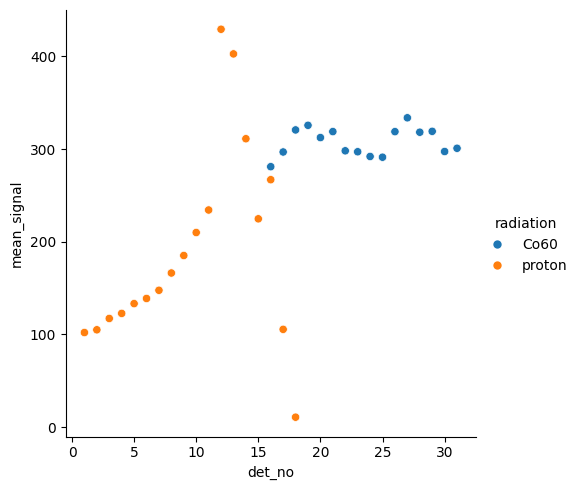

In [36]:
sns.relplot(data=df, x='det_no', y='mean_signal', hue='radiation', kind='scatter')

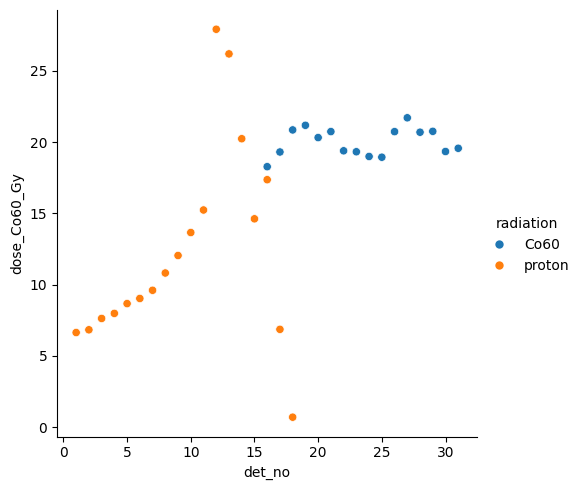

In [37]:
sns.relplot(data=df, x='det_no', y='dose_Co60_Gy', hue='radiation', kind='scatter')

In [38]:
# df.loc[df['radiation'] == 'proton', 'dose_Co60_Gy'] *= 1.1

# Bragg peak data from dosimetry and MC

In [39]:
#article_plots_path = Path(r"C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\publication_Measurement_2024\data_for_plots\article-plots.h5")
article_plots_path = base_path / "article-plots.h5"
df_bp_exp = pd.read_hdf(article_plots_path, key='bp_exp')
df_bp_mc = pd.read_hdf(article_plots_path, key='bp_mc')

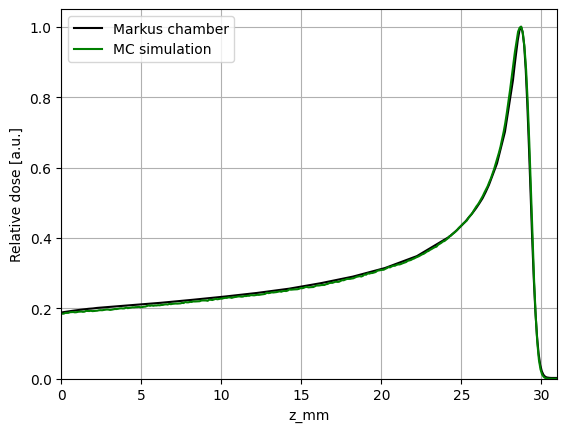

In [40]:
fig, ax = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax.set_ylim(0,1.05)
ax.set_xlim(0, 31)
ax.grid()
ax.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [ ]:
#det_pos_path = Path(r"C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\2024-11-21\fantom_MBO.xlsx")
#det_pos_path = base_path / Path("2024-12-21/fantom_MBO.xlsx")
det_pos_path = base_path / Path("2024-12-12/fantom_MBOvsEBT3.xlsx")
det_pos = pd.read_excel(
    det_pos_path,
    sheet_name='exp_11.12.2024',
    skiprows=5, 
    nrows=50, 
    usecols="A,D,F,H",
    names=["det_no", "det_type", "thickness_mm", "pos_center_mm"]
    )
det_pos = det_pos.query("det_type == 'folia MBO'").copy()
det_pos.reset_index(drop=True, inplace=True)
det_pos['det_no'] = det_pos['det_no'].astype(int)
#det_pos['pos_center_mm'] += 0.08
det_pos

,det_no,det_type,thickness_mm,pos_center_mm
0,1,folia MBO,0.48825,0.715050
1,2,folia MBO,0.47250,3.348700
2,3,folia MBO,0.46725,6.362775
3,4,folia MBO,0.47145,9.376325
4,5,folia MBO,0.47880,12.395650
5,6,folia MBO,0.49035,15.401625
6,7,folia MBO,0.48300,18.386900
7,8,folia MBO,0.47040,21.396400
8,9,folia MBO,0.47880,24.392400
9,10,folia MBO,0.48510,25.241150


In [42]:
df_with_pos = det_pos.join(df.set_index('det_no'), on='det_no').copy()
df_with_pos

,det_no,det_type,thickness_mm,pos_center_mm,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy
0,1,folia MBO,0.48825,0.715050,102.022087,28.158341,proton,27.600240,6.633864
1,2,folia MBO,0.47250,3.348700,104.983583,27.386678,proton,26.086629,6.826432
2,3,folia MBO,0.46725,6.362775,117.211326,29.037474,proton,24.773607,7.621526
3,4,folia MBO,0.47145,9.376325,122.670697,29.722597,proton,24.229582,7.976515
4,5,folia MBO,0.47880,12.395650,133.239343,30.886061,proton,23.180886,8.663729
5,6,folia MBO,0.49035,15.401625,138.772086,32.051308,proton,23.096366,9.023489
6,7,folia MBO,0.48300,18.386900,147.602721,32.741967,proton,22.182495,9.597690
7,8,folia MBO,0.47040,21.396400,166.252409,33.997225,proton,20.449162,10.810364
8,9,folia MBO,0.47880,24.392400,185.127414,35.276201,proton,19.055093,12.037689
9,10,folia MBO,0.48510,25.241150,209.919079,37.452993,proton,17.841634,13.649737


Text(0, 0.5, 'Dose [Gy]')

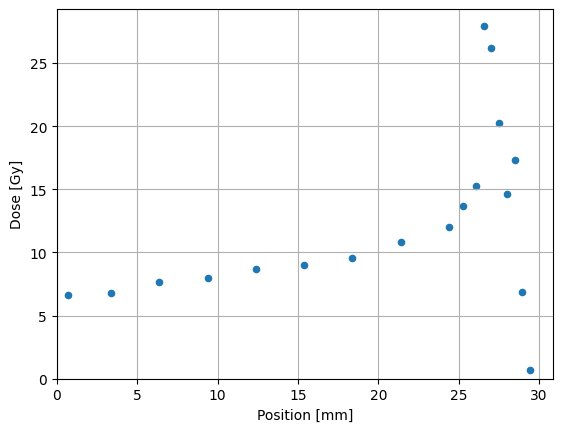

In [43]:
fig, ax = plt.subplots(nrows=1, sharex=True)
df_with_pos.query('radiation=="proton"').plot(x='pos_center_mm', y='dose_Co60_Gy', kind='scatter', ax = ax)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid()
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Dose [Gy]")

# Combining with MC

In [44]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose
from scipy.interpolate import interp1d
f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [45]:
df_with_pos['dose_interp'] = f(df_with_pos['pos_center_mm'])
df_with_pos['dose_interp'] /= df_with_pos['dose_interp'].iloc[0]
df_with_pos['dose_interp'] *= 7
df_with_pos

,det_no,det_type,thickness_mm,pos_center_mm,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy,dose_interp
0,1,folia MBO,0.48825,0.715050,102.022087,28.158341,proton,27.600240,6.633864,7.000000
1,2,folia MBO,0.47250,3.348700,104.983583,27.386678,proton,26.086629,6.826432,7.318824
2,3,folia MBO,0.46725,6.362775,117.211326,29.037474,proton,24.773607,7.621526,7.753224
3,4,folia MBO,0.47145,9.376325,122.670697,29.722597,proton,24.229582,7.976515,8.265816
4,5,folia MBO,0.47880,12.395650,133.239343,30.886061,proton,23.180886,8.663729,8.813251
5,6,folia MBO,0.49035,15.401625,138.772086,32.051308,proton,23.096366,9.023489,9.611080
6,7,folia MBO,0.48300,18.386900,147.602721,32.741967,proton,22.182495,9.597690,10.654349
7,8,folia MBO,0.47040,21.396400,166.252409,33.997225,proton,20.449162,10.810364,12.160458
8,9,folia MBO,0.47880,24.392400,185.127414,35.276201,proton,19.055093,12.037689,15.083121
9,10,folia MBO,0.48510,25.241150,209.919079,37.452993,proton,17.841634,13.649737,16.463512


(25.0, 30.0)

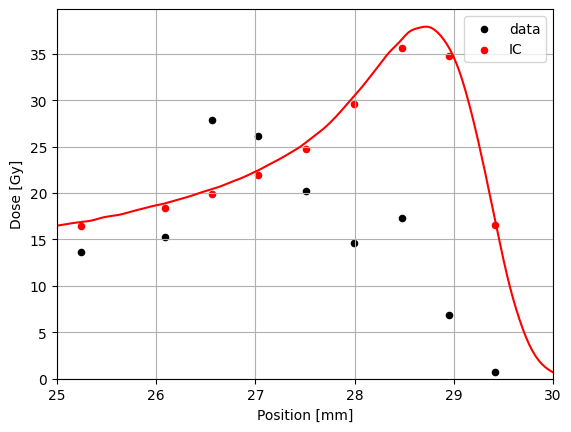

In [46]:
fig, ax = plt.subplots(nrows=1, sharex=True)
x_mm = np.linspace(0.05, 32, 1000)
dose_IC_Gy = f(x_mm) * 7 / f(df_bp_mc.z_mm.iloc[0])
df_with_pos.query('radiation=="proton"').plot(x='pos_center_mm', y='dose_Co60_Gy', kind='scatter', ax = ax, color='black', label='data')
df_with_pos.query('radiation=="proton"').plot(x='pos_center_mm', y='dose_interp', kind='scatter', ax = ax, color='red', label='IC')
ax.plot(x_mm, dose_IC_Gy, color='red')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid()
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Dose [Gy]")
ax.set_xlim(25, 30)

<Axes: xlabel='pos_center_mm', ylabel='efficiency'>

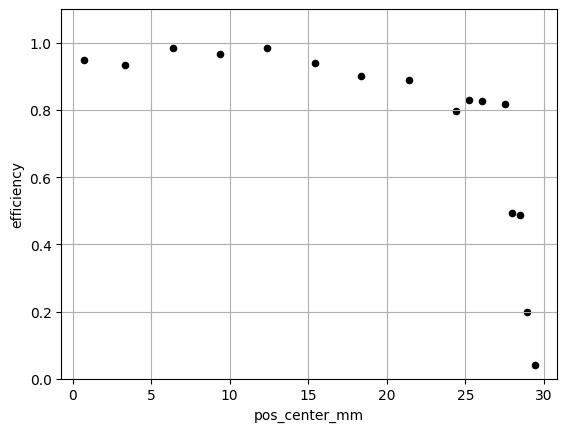

In [47]:
df_with_pos['efficiency'] = df_with_pos['dose_Co60_Gy'] / df_with_pos['dose_interp']
df_with_pos.query('radiation=="proton"').plot(x='pos_center_mm', y='efficiency', kind='scatter', color='black', grid=True, ylim=(0, 1.1))

In [48]:
df_with_pos.query('radiation=="proton"')

,det_no,det_type,thickness_mm,pos_center_mm,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy,dose_interp,efficiency
0,1,folia MBO,0.48825,0.715050,102.022087,28.158341,proton,27.600240,6.633864,7.000000,0.947695
1,2,folia MBO,0.47250,3.348700,104.983583,27.386678,proton,26.086629,6.826432,7.318824,0.932723
2,3,folia MBO,0.46725,6.362775,117.211326,29.037474,proton,24.773607,7.621526,7.753224,0.983014
3,4,folia MBO,0.47145,9.376325,122.670697,29.722597,proton,24.229582,7.976515,8.265816,0.965000
4,5,folia MBO,0.47880,12.395650,133.239343,30.886061,proton,23.180886,8.663729,8.813251,0.983034
5,6,folia MBO,0.49035,15.401625,138.772086,32.051308,proton,23.096366,9.023489,9.611080,0.938863
6,7,folia MBO,0.48300,18.386900,147.602721,32.741967,proton,22.182495,9.597690,10.654349,0.900824
7,8,folia MBO,0.47040,21.396400,166.252409,33.997225,proton,20.449162,10.810364,12.160458,0.888977
8,9,folia MBO,0.47880,24.392400,185.127414,35.276201,proton,19.055093,12.037689,15.083121,0.798090
9,10,folia MBO,0.48510,25.241150,209.919079,37.452993,proton,17.841634,13.649737,16.463512,0.829090


Text(0, 0.5, 'Dose [Gy]')

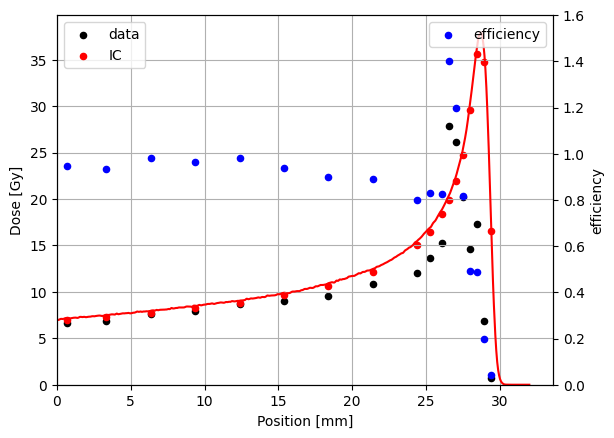

In [49]:
fig, ax = plt.subplots(nrows=1, sharex=True)
x_mm = np.linspace(0.05, 32, 1000)
dose_IC_Gy = f(x_mm) * 7 / f(df_bp_mc.z_mm.iloc[0])
df_with_pos.query('radiation=="proton"').plot(x='pos_center_mm', y='dose_Co60_Gy', kind='scatter', ax = ax, color='black', label='data')
df_with_pos.query('radiation=="proton"').plot(x='pos_center_mm', y='dose_interp', kind='scatter', ax = ax, color='red', label='IC')
ax_right = ax.twinx()
ax_right.set_ylabel("Efficiency")
ax_right.set_ylim(0, 1.6)
df_with_pos.query('radiation=="proton"').plot(x='pos_center_mm', y='efficiency', kind='scatter', ax = ax_right, color='blue', label='efficiency')
ax.plot(x_mm, dose_IC_Gy, color='red')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid()
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Dose [Gy]")